## DIstributed Shared Nearest Neighbor experiments

In [404]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end

#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",])
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",
#        "158.251.93.5:3304","158.251.93.5:3303","158.251.93.5:3302","158.251.93.5:3301",])

addprocs(["158.251.88.180:3301","158.251.88.180:3302","158.251.88.180:3303","158.251.88.180:3304",])

@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_Master.jl")

using PyCall
@pyimport clustering_scores as cs #clustering_scores.py must be in the path.
using JLD

Removing previous workers...


stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
stdin: is not a tty


[M] Starting Stage 1 (assignment distribution and corepoint identification)
	From worker 93:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 91:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 90:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 92:	[W] executing snn clustering with eps:0.9 and minpts:13
[M] Joining worker's results of Stage 1
Amount of noisy data points detected by worker 4:396
Amount of noisy data points detected by worker 2:409
Amount of noisy data points detected by worker 3:473
Amount of noisy data points detected by worker 5:388
[M] Corepoints (225) and Samples (891)
[M] Creating SNN graph with data retrieved from workers...
[M] Number of groups detected with retrieved data:15
[M] Retransmitting overall corepoints (Stage 2)...
	From worker 91:	[W] Labeling assigned instances from the oveall corepoints
	From worker 90:	[W] Labeling assigned instances from the oveall corepoints
	From worker 92:	[W] Label


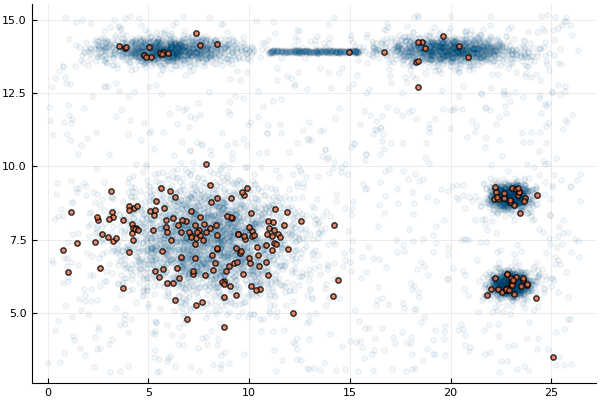

In [405]:
results = Dict{String,Any}();
DATA_PATH = "/workspace/cure_large.dat";
real_labels = vec(readdlm("/workspace/cure_large.dat.labels", Int32));

partitions = DSNN_Master.generate_partitions(length(workers()), 8100); # N must be extracted from the data.
overall_parameters = Dict{String, Any}("k"=>70, "snn_eps"=>0.9, "snn_minpts"=>13, "k_appindex"=>70);
DSNN_Master.start(results, DATA_PATH, partitions, 0.1, 5, worker_params=overall_parameters);
##
println("[Only for small 2D data] Plotting corepoints and whole dataset")
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);

colors = fill(1, size(D,2));
colors[results["stage1_corepoints"]] = 2;
plt = scatter(D[1,:], D[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
scatter!(plt, D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.8,:o,4), legend=false, fmt = :png)

The _start_ method sets the value of the dictionary _results_ by adding the following values:

* stage1_corepoints: Union of all corepoints identified by the Workers.
* stage1_sampled: Union of all the data points sampled by the Workers.
* stage1_graph: SNN Graph built with __all__ the data returned by the Workers.
* stage2_labels: Labels generated by the Workers after _stage 2_.


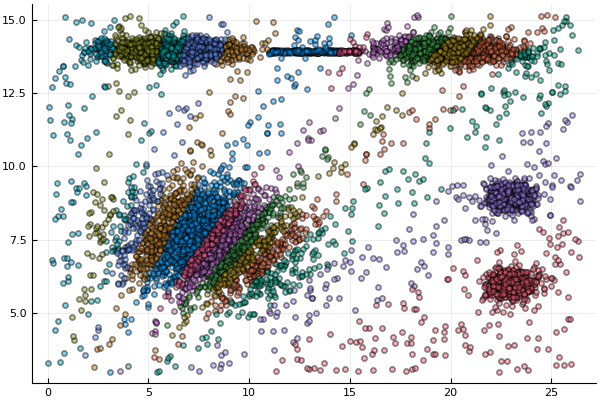

In [406]:
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
nonnoise = find(x->x>0,results["stage2_labels"]);
plt = scatter(D[1,nonnoise], D[2,nonnoise], marker=(0.5,:o,4), group=results["stage2_labels"][nonnoise], legend=false, fmt = :png)

### Working only with the retrieved corepoints

In [407]:
using Plots
pyplot()
using Graphs

D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
Dw = D[:,results["stage1_corepoints"]];
cp_real_labels = real_labels[results["stage1_corepoints"]];

CSV.write("/workspace/cure_corepoints.csv", DataFrames.DataFrame(full(transpose(Dw))), delim=' ',  header=false);
writedlm("/workspace/cure_corepoints.dat.labels", cp_real_labels, "\n");

snnmat, knnmat = DSNN_KNN.get_snnsimilarity(DSNN_IO.normalize_matrix(Dw), 20, l2knng_path="/workspace/l2knng/build/knng");
snn_graph = DSNN_KNN.get_snngraph(knnmat, snnmat);

### Applying SNN-Clustering to the corepoints

Num. Clusters found:15
Percentage of noise:: 0.08



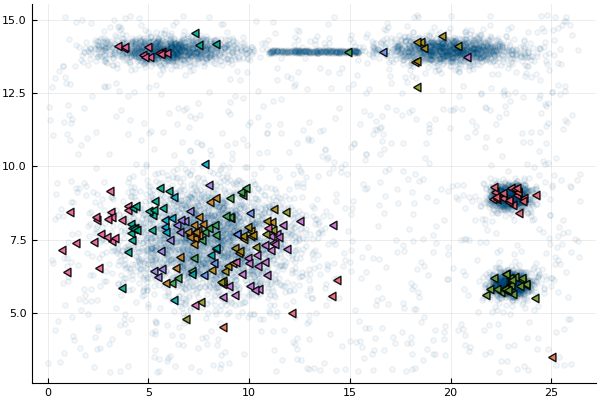

In [424]:
cp_results = DSNN_SNN.snn_clustering(0.8, 1, snn_graph);

labels_found = fill(0, size(cp_results["labels"],1));
for c in collect(1:size(cp_results["labels"],2))
    for i in cp_results["labels"][:,c].nzind
        labels_found[i] = cp_results["clusters"][c]; # extract the right assigned label name
    end
end

println("Num. Clusters found:",length(unique(labels_found)))
if length(find(x->x<0, cp_results["clusters"])) > 0
    println(@sprintf("Percentage of noise:: %0.2f", 
            length(cp_results["labels"][:,1].nzind)/size(cp_results["labels"],1)))
else
    println("Amount of noise: 0");
end
writedlm("/workspace/cure_corepoints.dat.dsnn_snn.labels", labels_found, "\n");

Plots.scatter(D[1,:], D[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
Plots.scatter!(Dw[1,:], Dw[2,:], marker=(0.9,:<,7), groups=labels_found, legend=false, fmt = :png)

#### Inspecting a particular cluster to appreciate the _far-away association_ phenomenon


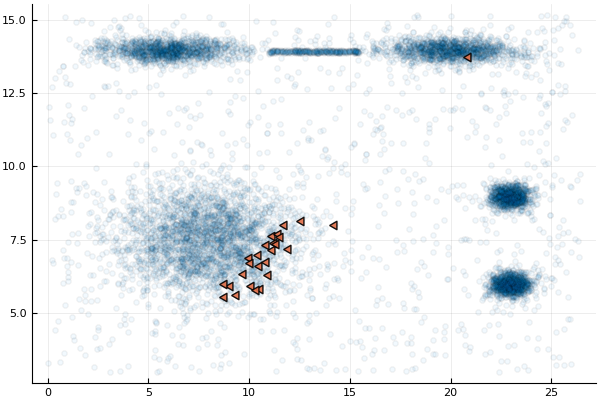

In [425]:
only_these_group = find(x->x in [2], labels_found);
Plots.scatter(D[1,:], D[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
Plots.scatter!(Dw[1,only_these_group], Dw[2,only_these_group], marker=(0.9,:<,7), groups=labels_found[only_these_group], legend=false, fmt = :png)

### Applying Connected Components to the corepoints

Num. points:225
Num. connected components:4
Num. Clusters found:4


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Array{Int64,1}}, ::Int64) at ./deprecated.jl:57
 [3] connected_components(::Graphs.GenericAdjacencyList{Int64,UnitRange{Int64},Array{Array{Int64,1},1}}) at /root/.julia/v0.6/Graphs/src/connected_components.jl:15
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] include_string(::Module, ::String, ::String) at /root/.julia/v0.6/Compat/src/Compat.jl:478
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /root/.julia/v0.6/IJulia/src/execute_request.jl:154
 [7] eventloop(::ZMQ.Socket) at /root/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[437], in expression starting on line 13
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Int64}, ::Int64) at ./deprecated.jl:57
 [3] Type at /root/.julia/v0.6/Graphs/src/graph_visit.jl:44 [inlined]
 [4] connected_components(::Graphs.GenericAdjacencyList{Int64,UnitRange{I


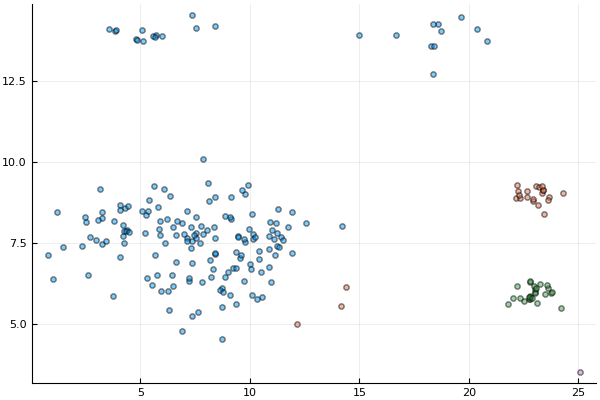

In [437]:
numpoints = size(Dw,2);
println("Num. points:",numpoints);
adj_mat = snn_graph;
#adj_mat = snnmat;

G = Graphs.simple_adjlist(numpoints, is_directed=false);
for i in collect(1:numpoints)
    for j in adj_mat[:,i].nzind
        Graphs.add_edge!(G, i, j)
    end
end

cmps = Graphs.connected_components(G);

println("Num. connected components:",length(cmps));
labels_found = fill(-1, numpoints);
for cmp_i in eachindex(cmps)
    for p in cmps[cmp_i]
        labels_found[p] = cmp_i;
    end
end
println("Num. Clusters found:",length(unique(labels_found)))
writedlm("/workspace/cure_corepoints.dat.dsnn_conncomps_labels", labels_found, "\n");

using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
plt = scatter(D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.5,:o,4), group=labels_found, legend=false, fmt = :png)

### Applying Maximal Clique to the corepoints

Num. points:225
Num. connected components:127
Num. Clusters found:48



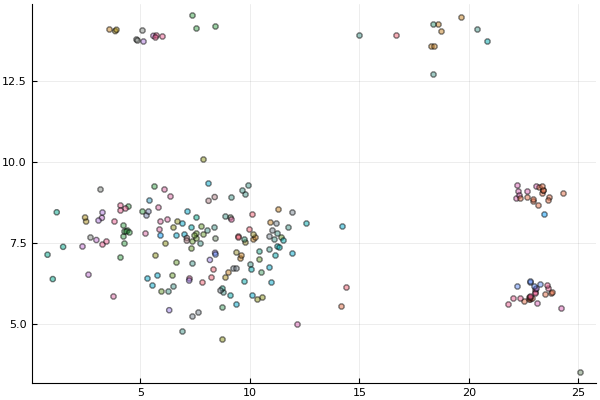

In [436]:
numpoints = size(Dw,2);
println("Num. points:",numpoints);
adj_mat = snn_graph;
#adj_mat = snnmat;

G = Graphs.simple_adjlist(numpoints, is_directed=false);
for i in collect(1:numpoints)
    for j in adj_mat[:,i].nzind
        Graphs.add_edge!(G, i, j)
    end
end

cmps = Graphs.maximal_cliques(G);

println("Num. connected components:",length(cmps));
labels_found = fill(-1, numpoints);
for cmp_i in eachindex(cmps)
    for p in cmps[cmp_i]
        labels_found[p] = cmp_i;
    end
end

println("Num. Clusters found:",length(unique(labels_found)))
writedlm("/workspace/cure_corepoints.dat.dsnn_cliques_labels", labels_found, "\n");

using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
plt = scatter(D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.5,:o,4), group=labels_found, legend=false, fmt = :png)

### Applying Label propagation to the corepoints

Num. Clusters found:12



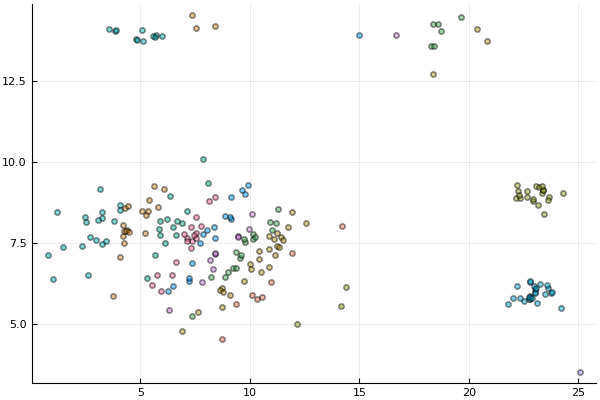

In [435]:
using LightGraphs

adj_mat = snn_graph;
#adj_mat = snnmat;

G = LightGraphs.Graph(numpoints)
for i in collect(1:numpoints)
   for j in adj_mat[:, i].nzind
       if j > i 
           # maybe a threshold based on snn_graph[j,i] could be used !
           if ~LightGraphs.add_edge!(G, i, j)
               println("[M] Error: Cannot add edge between vertices ",i," and ",j)
           end
       end
   end
end
labels_found, conv_history = LightGraphs.label_propagation(G);
println("Num. Clusters found:",length(unique(labels_found)))
writedlm("/workspace/cure_corepoints.dat.dsnn_lblprop_labels", labels_found, "\n");
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
plt = scatter(D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.5,:o,4), group=labels_found, legend=false, fmt = :png)

### Applying DBSCAN to the corepoints

Num. Clusters found:10



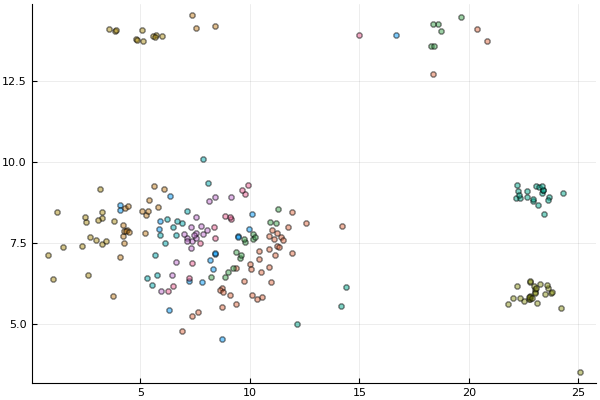

In [439]:
using Clustering

adj_mat = snnmat;

#dbscan_cl = Clustering.dbscan(full(Dw), 0.1, min_neighbors=15);
dbscan_cl = Clustering.dbscan(full(1.0 .- adj_mat), 0.3, 10);

labels_found = dbscan_cl.assignments;

println("Num. Clusters found:",length(unique(labels_found)))
writedlm("/workspace/cure_corepoints.dat.dsnn_dbscan_labels", labels_found, "\n");
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
plt = scatter(D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.5,:o,4), group=labels_found, legend=false, fmt = :png)

### ... END of grouping over corepoints

Distance to k-th neighbor (from SNN similarity matrix)



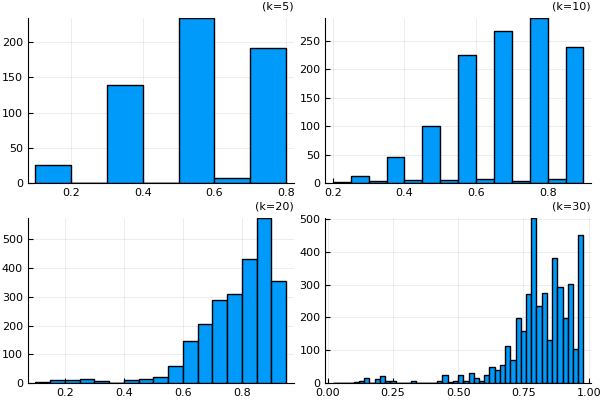

In [248]:
Dw = D[:,results["stage1_corepoints"]];

k_values = [5,10,20,30];
series = Array{Float64, 1}[];
for k in k_values
    snnmat, knnmat = DSNN_KNN.get_snnsimilarity(Dw, k, l2knng_path="/workspace/l2knng/build/knng");
    snn_graph = DSNN_KNN.get_snngraph(knnmat, snnmat);    
    #kdist_arr = plot_kdist_graph(snnmat_ap, k);
    
    push!(series, snn_graph.nzval);
end

println("Distance to k-th neighbor (from SNN similarity matrix)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

## Inspecting a single partition data

In [ ]:
using Plots
pyplot()

worker_assignment = find(x -> x==11, partitions);
Dw = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=true);

@time begin
println("Computing snn similarity...")
k=100;
#k_ap = 100; epsilon = 0.01;
#apix = DSNN_KNN.initialAppGraph(Dw, k_ap, epsilon, k_ap*2);
#DSNN_KNN.improve_graph!(apix, Dw, k_ap, epsilon, k_ap*2);

#knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k)#, sim_threshold = 0.15);
#snnmat_ap = DSNN_KNN.get_snnsimilarity(knnmat_ap, nbrhd_len)
knnmat_ap = DSNN_KNN.get_knn(Dw, 30);
snnmat_ap = transpose(knnmat_ap) * knnmat_ap;
sim_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);

#knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k, binarize=false);#, sim_threshold = 0.15);
#sim_graph = DSNN_KNN.get_knngraph(knnmat_ap);

println("SIM graph with nnz%",round(length(sim_graph.nzval)/size(sim_graph,1)^2,4))
end

@time begin
#eps=0.9500;minpts=5;
eps=0.7;minpts=5;
println("Executing snn clustering with eps:",eps," and minpts:", minpts)
results = DSNN_SNN.snn_clustering(eps, minpts, sim_graph);

labels_found = fill(0, size(results["labels"],1));
for c in collect(1:size(results["labels"],2))
    for i in results["labels"][:,c].nzind
        labels_ap[i] = results["clusters"][c]; # extract the right assigned label name
    end
end
end
# reporting results
println("Nr. of groups (+noise):",length(unique(labels_found)))
println(Stats.countmap(labels_found))
println("Amount of noise:",round(length(results["labels"][:,1].nzind)/size(results["labels"],1),2))
Dw_unnorm = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=false);
Plots.scatter(Dw_unnorm[1,:], Dw_unnorm[2,:], marker=(0.2,:o,4), groups=labels_found, legend=false, fmt = :png)
Plots.scatter!(Dw_unnorm[1,results["corepoints"]], Dw_unnorm[2,results["corepoints"]], marker=(0.9,:<,7), legend=false, fmt = :png)

In [ ]:
kdist_graph = plot_kdist_graph(snn_graph, k);
Plots.histogram(kdist_graph)

# Nueva Version

In [188]:
include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
using Plots
using Stats
using DataStructures
Plots.pyplot()

function plot_kdist_graph(p_snnmat::SparseMatrixCSC{Float64, Int64}, k::Int64)
    kdist_arr = Float64[];

    for i in collect(1:size(p_snnmat,2))
        # Base.Order.Reverse -> highest to lowest
        # Base.Order.Forward -> lowest to highest
        Q = DataStructures.PriorityQueue{Int64, Float64}(Base.Order.Reverse);
        nnzindices_i = p_snnmat[:,i].nzind;
        for j in nnzindices_i
            if j != i
                Q[j] = p_snnmat[j,i];#append similarity
            end
        end
        c = 1;
        xx = 0;
        while c < k && length(Q) > 0 # k-th extracted item will be the k-th lowest similarity (~ k-th highest distance)
            xx = DataStructures.peek(Q)[2];
            DataStructures.dequeue!(Q);
            c += 1;
        end

        push!(kdist_arr, xx);
    end
    sort!(kdist_arr); # ASC order of k-th neighbor similarity
    kdist_arr = 1.0 - kdist_arr; # now it is in Desc order of distances
    
    return kdist_arr
end

plot_kdist_graph (generic function with 1 method)

In [4]:
D = DSNN_IO.sparseMatFromFile("/workspace/cure_large.dat", l2normalize=false);
D = D .+ abs(minimum(D)); # correcting negative component values
Dnrm = DSNN_IO.normalize_matrix(D);

In [57]:
k = 70;
snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
snn_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);

Nr. of groups (+noise):226
Nr. of corepoints:225
Dict(11=>55,158=>14,134=>48,160=>14,215=>14,29=>49,131=>15,207=>37,173=>24,74=>21,201=>27,176=>27,57=>16,31=>25,70=>26,33=>31,114=>14,165=>23,96=>14,133=>17,49=>27,84=>17,117=>14,93=>2,50=>35,77=>30,80=>20,188=>14,132=>15,195=>45,157=>14,221=>14,153=>14,217=>15,79=>20,71=>18,120=>19,154=>16,225=>14,224=>27,76=>21,184=>14,167=>31,213=>16,204=>20,122=>14,143=>14,62=>19,107=>15,169=>17,21=>47,10=>24,102=>40,180=>19,162=>59,129=>15,88=>24,149=>14,5=>25,63=>9,15=>62,41=>16,148=>15,210=>17,55=>22,66=>44,155=>14,150=>17,209=>25,95=>26,139=>43,90=>25,111=>24,14=>37,175=>14,205=>51,212=>36,200=>43,135=>24,125=>25,172=>21,146=>14,130=>18,17=>28,65=>22,202=>19,44=>19,37=>45,192=>26,110=>42,127=>17,13=>32,-2=>2653,99=>16,137=>19,141=>23,105=>19,1=>52,30=>45,47=>14,216=>19,214=>15,91=>15,128=>14,9=>20,43=>25,203=>18,147=>6,104=>29,183=>14,103=>24,152=>15,118=>14,38=>39,48=>34,100=>15,81=>33,140=>18,196=>45,19=>22,51=>30,191=>18,177=>11,123=>19,163=>2


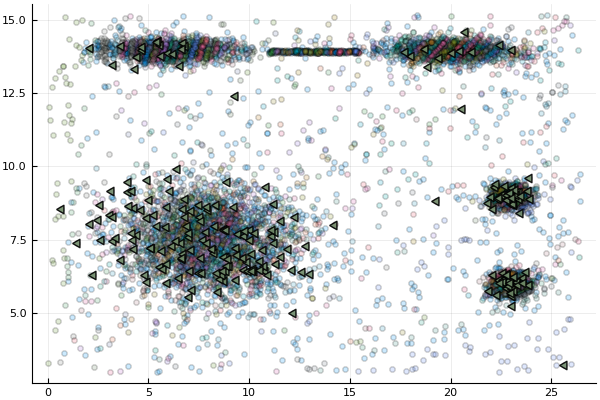

In [59]:
#results = DSNN_SNN.snn_clustering(0.9, 12, snnmat_ap);
results = DSNN_SNN.snn_clustering(0.9, 13, snn_graph);
#results = DSNN_SNN.snn_clustering(0.9, 12, snn_graph);

labels_found = fill(0, size(results["labels"],1));
for c in collect(1:size(results["labels"],2))
    for i in results["labels"][:,c].nzind
        labels_found[i] = results["clusters"][c]; # extract the right assigned label name
    end
end

# reporting results
println("Nr. of groups (+noise):",length(unique(labels_found)))
println("Nr. of corepoints:",length(results["corepoints"]))
println(Stats.countmap(labels_found))
if length(find(x->x<0, results["clusters"])) > 0
    println("Amount of noise:",round(length(results["labels"][:,1].nzind)/size(results["labels"],1),2))
else
    println("Amount of noise:0");
end
Plots.scatter(D[1,:], D[2,:], marker=(0.2,:o,4), groups=labels_found, legend=false, fmt = :png)
Plots.scatter!(D[1,results["corepoints"]], D[2,results["corepoints"]], marker=(0.9,:<,7), legend=false, fmt = :png)

Distance to k-th neighbor (from SNN similarity matrix)



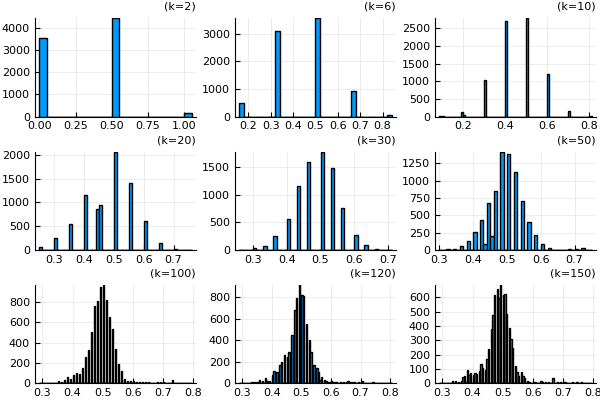

In [15]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
    kdist_arr = plot_kdist_graph(snnmat_ap, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from SNN similarity matrix)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

Distance to k-th neighbor (from filtered SNN similarity matrix)



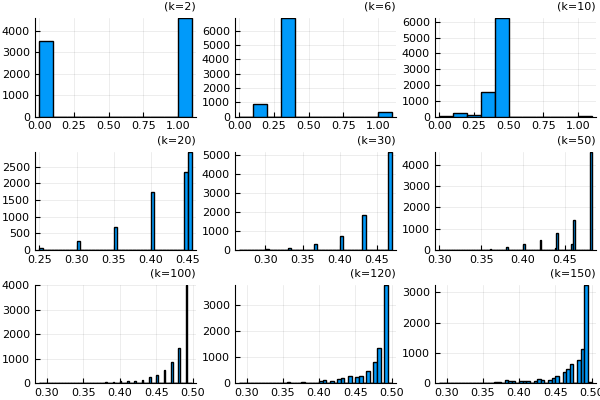

In [17]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, min_threshold=0.5, l2knng_path="/workspace/l2knng/build/knng");    
    kdist_arr = plot_kdist_graph(snnmat_ap, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from filtered SNN similarity matrix)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

Distance to k-th neighbor (from SNN Graph)



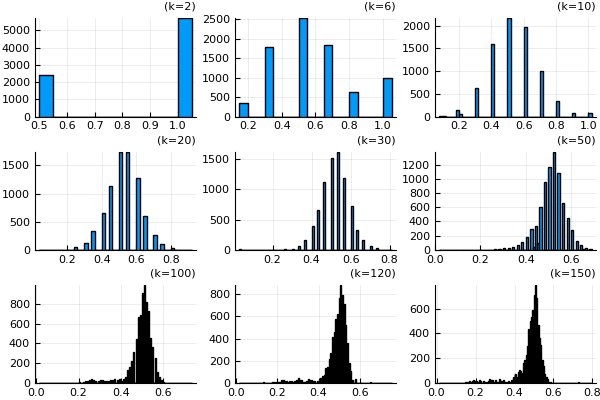

In [18]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
    snn_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);
    kdist_arr = plot_kdist_graph(snn_graph, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from SNN Graph)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)


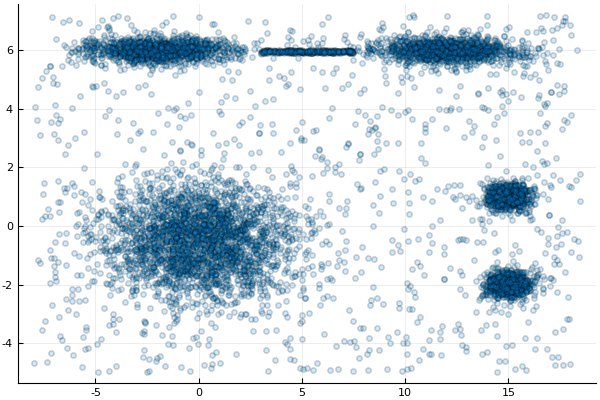

In [397]:
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
Plots.scatter(D[1,:], D[2,:], marker=(0.2,:o,4),legend=false, fmt = :png)


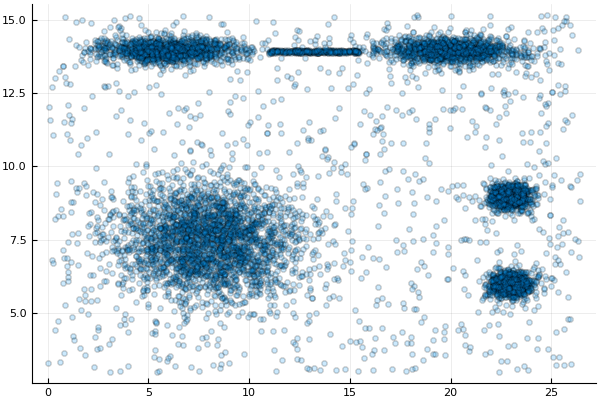

In [401]:
newD = D + abs(minimum(D));
#DSNN_IO.normalize_matrix!(newD);
Plots.scatter(newD[1,:], newD[2,:], marker=(0.2,:o,4),legend=false, fmt = :png)

In [403]:
DSNN_IO.sparseMatToFile(newD, "/workspace/cure_large.dat");